# PipLine of Submission

- model part: 'train' data loading, model training
- predict: prediction result
- save: save prediction in appropriate format

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb

from utils import helper
from utils import DataLoader, DataProcesser

%load_ext autoreload
%autoreload 2

# Data

- combine train dataset & validate dataset to new 'train' data

In [2]:
data_df = pd.read_csv('data/mid_res/20210526_data_df.csv')
val_df = pd.read_csv('data/mid_res/20210526_val_df.csv')
df = pd.concat([data_df, val_df], axis = 0)

In [3]:
col_drop_x = ['time', 'label']
col_label = 'label'
col_drop = ['latitude',
 'longitude',
 'altitude',
 'time_dlt',
 'valid_dlt',
 'east',
 'north',
 'east_dlt',
 'north_dlt',
 'east_speed',
 'north_speed',
 'cells_ctype_mode',
 'speed_dif',
 'speed_dlt',
 'speed'
 ]

In [5]:
test_ratio = 0.1
X = df.drop(col_drop_x + col_drop, axis = 1).fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, df[col_label], test_size = test_ratio, random_state = 999)

# Model

## Random Forest

In [6]:
model_rf = RandomForestClassifier(n_estimators = 20, random_state = 0, max_depth = 8)
model_rf.fit(X_train, y_train)
pred_rf = model_rf.predict(X_test) # label predict
pred_prob_rf = model_rf.predict_proba(X_test) # prob predict

[[12417  1534    21   134   183   613  1175   790]
 [  527 11643   816   475   101   198    79    48]
 [    1   181  2738    87     2     3     0     0]
 [  119   404   798 10443  1345   940   245   127]
 [    9    20     3   451 12744  1177  1489   399]
 [  165   322    83  1129  2087 10846  2265  1084]
 [  479   293     2    35  1698  1117 11848   896]
 [ 1393   558     2   135    40   105   662 10726]]
              precision    recall  f1-score   support

       Still       0.82      0.74      0.78     16867
     Walking       0.78      0.84      0.81     13887
         Run       0.61      0.91      0.73      3012
        Bike       0.81      0.72      0.76     14421
         Car       0.70      0.78      0.74     16292
         Bus       0.72      0.60      0.66     17981
       Train       0.67      0.72      0.69     16368
      Subway       0.76      0.79      0.77     13621

    accuracy                           0.74    112449
   macro avg       0.73      0.76      0.74    11

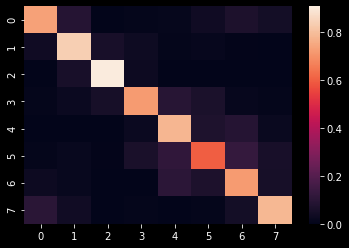

In [7]:
helper.evaluate(pred_rf, y_test)

## Bagging

In [8]:
model_bag = BaggingClassifier(DecisionTreeClassifier(), n_estimators = 100, max_samples = 100, bootstrap=True)
model_bag.fit(X_train, y_train)
pred_bag = model_bag.predict(X_test)
pred_prob_bag = model_bag.predict_proba(X_test)

[[11570  1374    19   150   397  1398  1842   910]
 [  732 11577  1229   537   138   355   154   119]
 [    8   261  2292   276     8    18     1     0]
 [   89   368   851  9931  1184  1386   218   217]
 [    8    59     3   957 12868  1746  3061  1201]
 [  134   238    61   851  1783  8133  1685   867]
 [  654   222     2    57  1777  1759  9671  1288]
 [ 1915   856     6   130    45   204  1131  9468]]
              precision    recall  f1-score   support

       Still       0.77      0.66      0.71     17660
     Walking       0.77      0.78      0.78     14841
         Run       0.51      0.80      0.63      2864
        Bike       0.77      0.70      0.73     14244
         Car       0.71      0.65      0.68     19903
         Bus       0.54      0.59      0.57     13752
       Train       0.54      0.63      0.58     15430
      Subway       0.67      0.69      0.68     13755

    accuracy                           0.67    112449
   macro avg       0.66      0.69      0.67    11

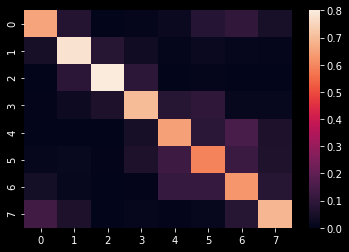

In [9]:
helper.evaluate(pred_bag, y_test)

## LightGBM

In [10]:
train_data = lgb.Dataset(X_train, label = y_train - 1)
test_data = lgb.Dataset(X_test, label = y_test - 1)
params={
    'learning_rate':0.1,
    'lambda_l1':0.1,
    'lambda_l2':0.2,
    'max_depth':6,
    'objective':'multiclass',
    'num_class':8,  
}
model_lgb = lgb.train(params, train_data, valid_sets = [test_data])

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4954
[LightGBM] [Info] Number of data points in the train set: 1012036, number of used features: 32
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score -1.999541
[LightGBM] [Info] Start training from score -2.022178
[LightGBM] [Info] Start training from score -3.216272
[LightGBM] [Info] Start training from score -2.161442
[LightGBM] [Info] Start training fro

In [11]:
pred_prob_lgb = model_lgb.predict(X_test)
pred_lgb = pred_prob_lgb.argmax(axis = 1) + 1

[[14420   242     0    78    47   114   146   105]
 [  231 13841   120   261    60    74    48    43]
 [    2   132  4095   139    13     6     3     0]
 [   78   202   231 12087   513   167    69    20]
 [   13    15     1   221 16921   818   681   173]
 [   19    80    12    63   236 13527   369   124]
 [  101   130     3    32   375   269 16358   204]
 [  246   313     1     8    35    24    89 13401]]
              precision    recall  f1-score   support

       Still       0.95      0.95      0.95     15152
     Walking       0.93      0.94      0.93     14678
         Run       0.92      0.93      0.93      4390
        Bike       0.94      0.90      0.92     13367
         Car       0.93      0.90      0.91     18843
         Bus       0.90      0.94      0.92     14430
       Train       0.92      0.94      0.93     17472
      Subway       0.95      0.95      0.95     14117

    accuracy                           0.93    112449
   macro avg       0.93      0.93      0.93    11

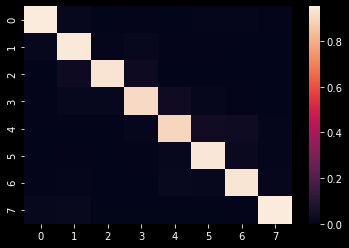

In [12]:
helper.evaluate(pred_lgb, y_test)

# Ensemble

In [13]:
def get_pred_mode(sr):
    ct = Counter(sr).most_common()[0]
    return ct[0] if ct[1] >= 2 else sr[2]


In [14]:
df_res = pd.DataFrame({"rf": pred_rf, "bag": pred_bag, "lgb": pred_lgb, "label": y_test})
df_res['pred'] = df_res.apply(lambda x: get_pred_mode(x[['rf', 'bag', 'lgb']]), axis = 1)

[[12953  1241    13   120    96   551  1084   505]
 [  510 12224   707   426    92   172    76    49]
 [    1   146  3035   110     2     4     0     0]
 [   98   336   663 11017  1085   744   154    96]
 [    8    22     2   396 14085  1116  1330   341]
 [   88   205    39   661  1485 11562  1629   640]
 [  318   212     2    27  1321   812 12922   612]
 [ 1134   569     2   132    34    38   568 11827]]
              precision    recall  f1-score   support

       Still       0.86      0.78      0.82     16563
     Walking       0.82      0.86      0.84     14256
         Run       0.68      0.92      0.78      3298
        Bike       0.85      0.78      0.81     14193
         Car       0.77      0.81      0.79     17300
         Bus       0.77      0.71      0.74     16309
       Train       0.73      0.80      0.76     16226
      Subway       0.84      0.83      0.83     14304

    accuracy                           0.80    112449
   macro avg       0.79      0.81      0.80    11

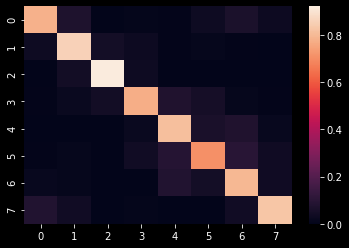

In [15]:
helper.evaluate(df_res['pred'], df_res['label'])

# Test Data

In [19]:
# test = DataLoader.SHLDataLoader('data/test/', ratio = None)
# test.load_all()
# dp = DataProcesser.DataProcesser(test)
# dp.process_pipe()
# test_time = pd.read_table('data/example_submission/teamName_predictions.txt', header = None, names = ['time', 'label'], sep = "\t")['time']
# test.df = pd.merge(test_time, test.df, on = ['time'], how = 'left')
with open('data/mid_res/test.pickle', 'rb') as f:  
    test = pickle.load(f)

In [20]:
X_test2 = test.df.drop(['time'] + col_drop, axis = 1).fillna(0)

In [21]:
pred2_rf = pd.Series(model_rf.predict(X_test2))
pred2_bag = pd.Series(model_bag.predict(X_test2))
pred2_lgb = pd.Series(model_lgb.predict(X_test2).argmax(axis = 1) + 1)

In [22]:
pred2_prob_rf = model_rf.predict_proba(X_test2)
pred2_prob_bag = model_bag.predict_proba(X_test2)
pred2_prob_lgb = model_lgb.predict(X_test2)

In [23]:
# add prob + window mean
pred2_prob = pred2_prob_rf + pred2_prob_bag + pred2_prob_lgb
pred2_prob_mean = pd.DataFrame(pred2_prob).rolling(100, center = True).mean().fillna(method = 'ffill').fillna(method = 'bfill')
pred2_mean = pd.Series(np.array(pred2_prob_mean).argmax(axis = 1) + 1)

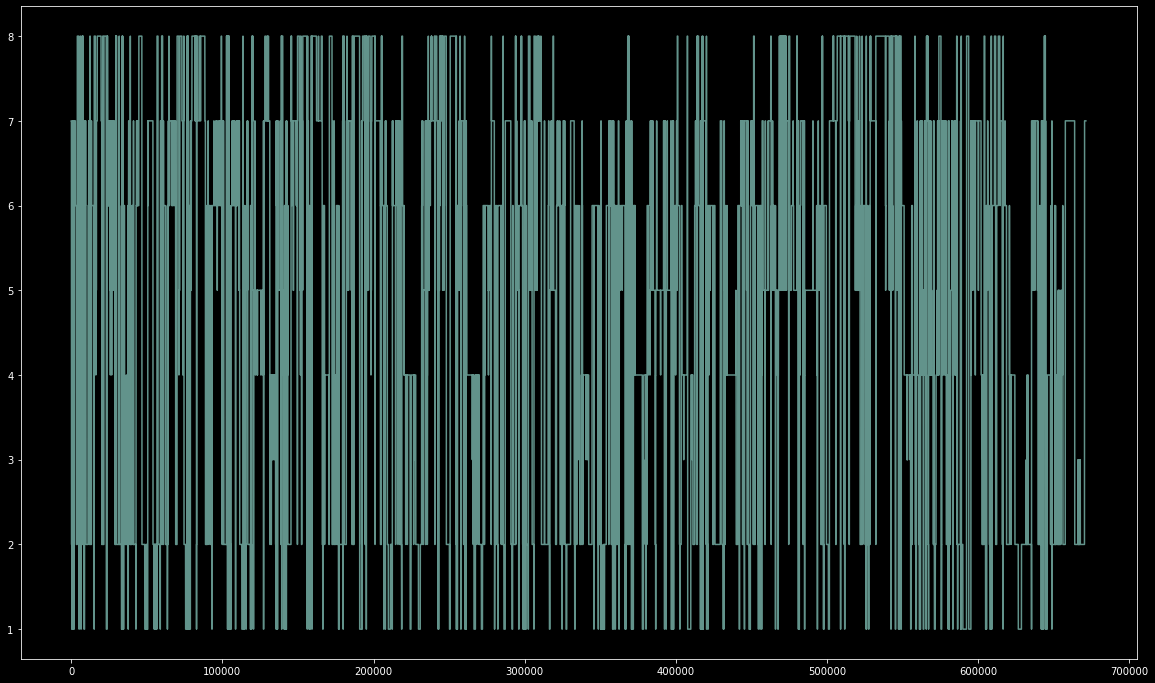

In [24]:
plt.figure(figsize = [20, 12])
plt.plot(pred2_mean, alpha = 0.7)

# Save Result

In [25]:
Counter(pred2_mean)

Counter({7: 123048,
         2: 144772,
         1: 53368,
         6: 102116,
         8: 96806,
         4: 69336,
         5: 78363,
         3: 3363})

In [76]:
def save_prediction(pred_time, pred_res, file_path = 'data/RY_predictions.txt'):
    res = pd.DataFrame({'time': pred_time, 'label': pred_res})
    res.to_csv(file_path, index = False, header = False, sep = '\t')

In [75]:
# save_prediction(test.df.time, pred, 'data/RY_predictions.txt')